# Classification models with resampling techniques

We have seen in the previous notebook that the training of the models took a long time. And the model we chose, KNN, for its characteristics, is slow to train due to the distance calculation between the points.
In this notebook, we will use resampling techniques to reduce the training time of the models.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import joblib

from imblearn.under_sampling import NearMiss

from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    PowerTransformer,
    StandardScaler,
)
from sklearn.utils.class_weight import compute_class_weight

from sklearn.dummy import DummyClassifier

# linear models
from sklearn.linear_model import LogisticRegression

# tree models
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

# svm
from sklearn.svm import SVC

# kNN
from sklearn.neighbors import KNeighborsClassifier

from collections import Counter

from fraud.config import BEST_MODEL_FILE, PROCESSED_DATA_FILE
from fraud.plots import (
    plot_model_performance_metrics,
    plot_ks_curve,
)
from fraud.models import RANDOM_STATE
from fraud.models import (
    get_mean_and_std_from_grid_search_best_estimator,
    grid_search_cv_classifier,
    train_and_validate_classification_model,
    summarize_model_performance,
)

In [2]:
df = pd.read_parquet(PROCESSED_DATA_FILE, engine="fastparquet")

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262594 entries, 0 to 262593
Data columns (total 28 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    262594 non-null  float64
 1   V1      262594 non-null  float64
 2   V2      262594 non-null  float64
 3   V3      262594 non-null  float64
 4   V4      262594 non-null  float64
 5   V5      262594 non-null  float64
 6   V6      262594 non-null  float64
 7   V7      262594 non-null  float64
 8   V8      262594 non-null  float64
 9   V9      262594 non-null  float64
 10  V10     262594 non-null  float64
 11  V11     262594 non-null  float64
 12  V12     262594 non-null  float64
 13  V14     262594 non-null  float64
 14  V16     262594 non-null  float64
 15  V17     262594 non-null  float64
 16  V18     262594 non-null  float64
 17  V19     262594 non-null  float64
 18  V20     262594 non-null  float64
 19  V21     262594 non-null  float64
 20  V23     262594 non-null  float64
 21  V24     26

## Preprocessing setup


Prior to building the model, we need to preprocess the data. We will start by defining the target variable and the features:

In [4]:
X = df.drop(columns=["Class"])
y = df["Class"]

le = LabelEncoder()
y = le.fit_transform(y.values.ravel())

X.shape, y.shape

((262594, 27), (262594,))

In [5]:
le.classes_

array([0, 1], dtype=int8)

In [6]:
y[:5]

array([0, 0, 0, 0, 0])

We will follow the same procedures of the previous notebook to preprocess the data.

In [7]:
columns_power_transform = ["Time", "Amount"]
target = ["Class"]

columns_robust_scaler = [
    column for column in X.columns if column not in columns_power_transform
]

columns_robust_scaler

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28']

In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [9]:
preprocessing_not_tree = ColumnTransformer(
    transformers=[
        ("power_transform", PowerTransformer(), columns_power_transform),
        ("robust_scaler", StandardScaler(), columns_robust_scaler),
    ],
    remainder="passthrough",
)

Now, let's define our resampling strategy. We are going to use an undersampling technique called NearMiss. This technique selects points of the majority class that are going to be removed. This way, we will have a balanced dataset, and we will be able to train the models faster.

You can learn more about the NearMiss technique on the [imbalanced-learn documentation](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html).

As can be seen in the docs, there are 3 versions of NearMiss: NearMiss-1, NearMiss-2, and NearMiss-3. 
NearMiss-3 is a 2-steps algorithm. First, for each negative sample, their nearest-neighbors will be kept. Then, the positive samples selected are the one for which the average distance to the nearest-neighbors is the largest.

See below that we used the value `1/2` for the parameter `sampling_strategy`. This value means that we want a final dataset with a proportion of 1:2 between the minority and majority classes. This is still an imbalanced dataset, but it is far less imbalanced than the original dataset so that the models can learn better.

In [10]:
resampling = NearMiss(version=3, n_jobs=-1, sampling_strategy=1/2)

In [11]:
X_resampled, y_resampled = resampling.fit_resample(X, y)

Counter(y), Counter(y_resampled)

(Counter({np.int64(0): 262102, np.int64(1): 492}),
 Counter({np.int64(0): 984, np.int64(1): 492}))

In [12]:
class_weight_proportion = compute_class_weight(
    "balanced", classes=np.unique(y_resampled), y=y_resampled
)
class_weight_ratio = class_weight_proportion[1] / class_weight_proportion[0]
class_weight_ratio

np.float64(2.0)

Let's define our classifiers and see the results. The reasonings are the same as in the previous notebook.

In [13]:
classifiers = {
    "DummyClassifier": {
        "preprocessor": None,
        "classifier": DummyClassifier(strategy="stratified"),
        "resampling": resampling,
    },
    "LogisticRegression": {
        "preprocessor": preprocessing_not_tree,
        "classifier": LogisticRegression(class_weight="balanced"),
        "resampling": resampling,
    },
    "DecisionTreeClassifier": {
        "preprocessor": None,
        "classifier": DecisionTreeClassifier(class_weight="balanced"),
        "resampling": resampling,
    },
    "LGBMClassifier": {
        "preprocessor": None,
        "classifier": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            scale_pos_weight=class_weight_ratio,
        ),
        "resampling": resampling,
    },
    "SVC": {
        "preprocessor": preprocessing_not_tree,
        "classifier": SVC(
            class_weight="balanced",
            cache_size=2048,
            random_state=RANDOM_STATE,
            probability=True,
        ),
        "resampling": resampling,
    },
    "KNeighborsClassifier": {
        "preprocessor": preprocessing_not_tree,
        "classifier": KNeighborsClassifier(n_jobs=-1),
        "resampling": resampling,
    },
}

In [14]:
results = {
    model_name: train_and_validate_classification_model(X, y, kf, **classifier)
    for model_name, classifier in classifiers.items()
}

df_results = summarize_model_performance(results)

df_results

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,test_neg_brier_score,test_f1_weighted,time_seconds
0,DummyClassifier,0.378134,0.037108,0.665607,0.506571,0.003857,0.001939,0.346939,0.476197,0.00179,-0.334031,0.797596,0.415242
1,DummyClassifier,0.332121,0.032018,0.664026,0.470131,0.003051,0.001534,0.27551,0.46647,0.001766,-0.333118,0.796488,0.364139
2,DummyClassifier,0.673946,0.037754,0.664312,0.47393,0.003166,0.001592,0.282828,0.475552,0.001807,-0.332451,0.796674,0.7117
3,DummyClassifier,0.693711,0.035402,0.667225,0.53084,0.004443,0.002234,0.393939,0.520081,0.00197,-0.334127,0.798724,0.729113
4,DummyClassifier,0.566198,0.031759,0.670532,0.509038,0.003915,0.001968,0.346939,0.526718,0.001981,-0.334838,0.801133,0.597957
5,LogisticRegression,1.654954,0.158965,0.950132,0.924095,0.06297,0.032629,0.897959,0.946104,0.838313,-0.051934,0.972684,1.813919
6,LogisticRegression,1.393071,0.137156,0.901712,0.884561,0.031883,0.01624,0.867347,0.937911,0.827189,-0.078066,0.946518,1.530227
7,LogisticRegression,1.490656,0.144956,0.909461,0.899195,0.035693,0.018212,0.888889,0.954323,0.803067,-0.071559,0.950773,1.635612
8,LogisticRegression,1.415216,0.134678,0.874598,0.856525,0.024585,0.012476,0.838384,0.94957,0.793116,-0.094476,0.931279,1.549894
9,LogisticRegression,1.480526,0.189091,0.895084,0.906704,0.031634,0.016094,0.918367,0.952113,0.849369,-0.082452,0.942834,1.669616


In [15]:
df_results.groupby("model").mean().sort_values(
    "test_average_precision"
)

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,test_neg_brier_score,test_f1_weighted,time_seconds
model,,,,,,,,,,,,
DummyClassifier,0.528822,0.034808,0.66634,0.498102,0.003686,0.001854,0.329231,0.493004,0.001863,-0.333713,0.798123,0.56363
DecisionTreeClassifier,0.488313,0.035643,0.94608,0.921262,0.058827,0.030416,0.896351,0.921262,0.027456,-0.05392,0.970531,0.523956
KNeighborsClassifier,1.534785,2.200895,0.989379,0.91355,0.24084,0.142572,0.837436,0.938418,0.757573,-0.028032,0.993238,3.73568
LogisticRegression,1.486885,0.152969,0.906197,0.894216,0.037353,0.01913,0.882189,0.948004,0.822211,-0.075697,0.948817,1.639854
SVC,1.555189,2.831963,0.99968,0.914688,0.906547,1.0,0.829375,0.940962,0.865117,-0.008887,0.999665,4.387152
LGBMClassifier,1.631932,0.216725,0.99067,0.941614,0.266153,0.15673,0.892373,0.982752,0.865668,-0.00734,0.993939,1.848657


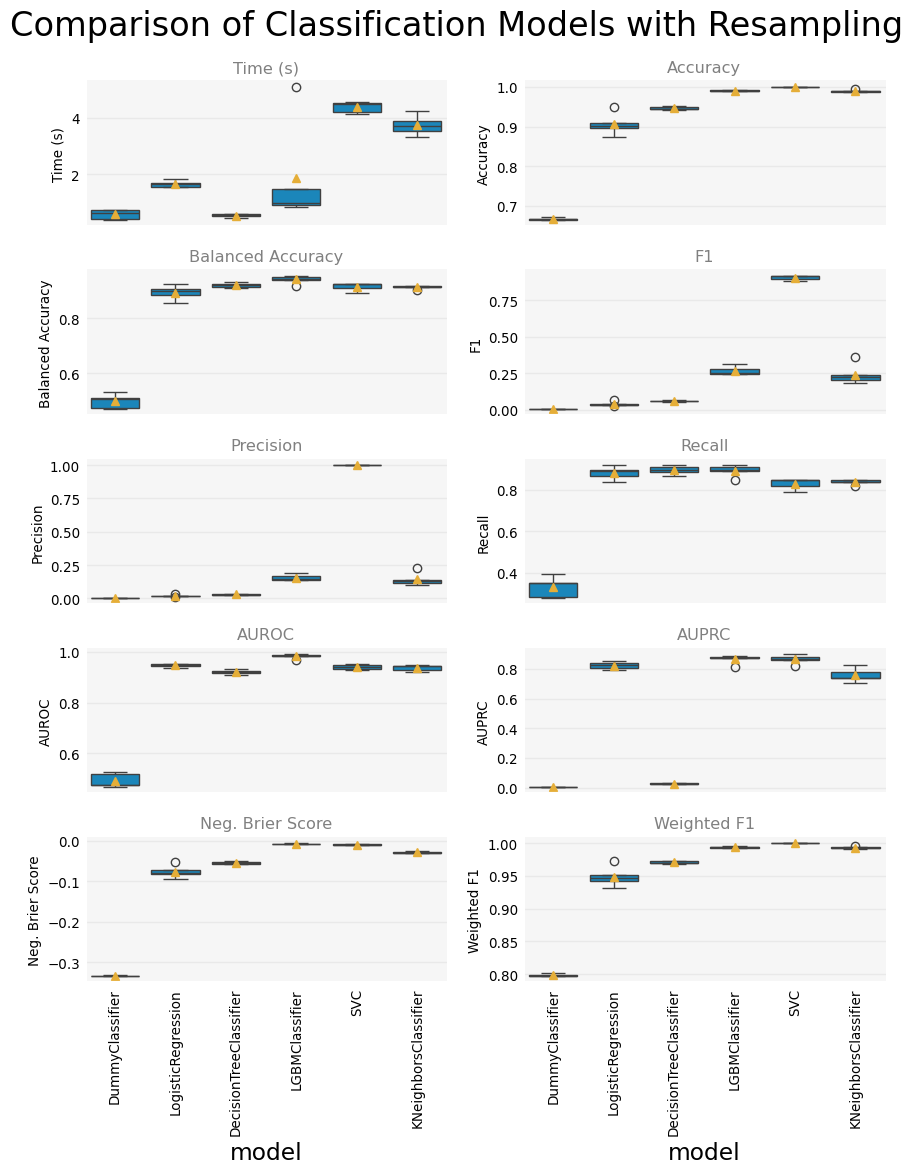

In [16]:
plot_model_performance_metrics(df_results, title="Comparison of Classification Models with Resampling")

It is interesting that the performance of KNN degraded a lot. Since we removed a lot of points from the majority class, and the removal considered the nearest neighbors, the KNN algorithm lost a lot of information.

However, our dataset now is small enough for algorithms like SVC to perform well. Even though it is not the best model concerning our metric of choice (it is the second best), it is the only model to have a good balance between precision and recall. This is important because we want to predict the minority class, and we don't want to have a lot of false positives.

It is the slowest model of all, but since we have a small dataset, it is not a problem now as it was before. Comparing, the SVC training after resampling is almost 10 times faster than the KNN training before resampling.

It is now possible to optimize the SVC model in a reasonable time.

## Fine-tuning the hyperparameters of the best model

For fine-tuning the hyperparameters, we will use the `GridSearchCV` class from the sklearn library. This class allows us to search for the best hyperparameters of a model by testing different combinations of hyperparameters.

In [17]:
param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto", 1],
    "clf__kernel": ["rbf", "linear"],
}

In [18]:
clf = SVC(
    cache_size=2048,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    probability=True,
)

grid_search = grid_search_cv_classifier(
    clf,
    param_grid,
    kf,
    preprocessing_not_tree,
    refit_metric="average_precision",
    resampling=resampling,
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('power_transform',
                                                                         PowerTransformer(),
                                                                         ['Time',
                                                                          'Amount']),
                                                                        ('robust_scaler',
                                                                         StandardScaler(),
                                                                         ['V1',
                                                                          'V2',
                                                                          'V3',
                                                                          'V4',
                                                                          'V5',
                                                                          'V6',
                                                                          'V7',
                                                                          'V8',
                                                                          'V9',
                                                                          'V10',
                                                                          'V11',
                                                                          'V12',
                                                                          'V14',
                                                                          'V16',
                                                                          'V17',
                                                                          'V18',...
                                        SVC(cache_size=2048,
                                            class_weight='balanced',
                                            probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'clf__gamma': ['scale', 'auto', 1],
                         'clf__kernel': ['rbf', 'linear']},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision',
                      'neg_brier_score', 'f1_weighted'],
             verbose=1)

In [19]:
grid_search.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/anaconda/envs/ifood_case/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda/envs/ifood_case/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('power_transform',
                                                                         PowerTransformer(),
                                                                         ['Time',
                                                                          'Amount']),
                                                                        ('robust_scaler',
                                                                         StandardScaler(),
                                                                         ['V1',
                                                                          'V2',
                                                                          'V3',
                                                                          'V4',
                                                                          'V5',
                                                                          'V6',
                                                                          'V7',
                                                                          'V8',
                                                                          'V9',
                                                                          'V10',
                                                                          'V11',
                                                                          'V12',
                                                                          'V14',
                                                                          'V16',
                                                                          'V17',
                                                                          'V18',...
                                        SVC(cache_size=2048,
                                            class_weight='balanced',
                                            probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'clf__gamma': ['scale', 'auto', 1],
                         'clf__kernel': ['rbf', 'linear']},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision',
                      'neg_brier_score', 'f1_weighted'],
             verbose=1)

In [20]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('power_transform',
                                                  PowerTransformer(),
                                                  ['Time', 'Amount']),
                                                 ('robust_scaler',
                                                  StandardScaler(),
                                                  ['V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V14',
                                                   'V16', 'V17', 'V18', 'V19',
                                                   'V20', 'V21', 'V23', 'V24',
                                                   'V25', 'V26', 'V27',
                                                   'V28'])])),
                ('resampling',
                 NearMiss(n_jobs=-1, sampling_strategy=0.5, version=3)),
                ('clf',
                 SVC(C=1, cache_size=2048, class_weight='balanced',
                     probability=True, random_state=42))])

In [21]:
grid_search.best_params_

{'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

In [22]:
grid_search.best_score_

np.float64(0.8651166621644251)

In [23]:
get_mean_and_std_from_grid_search_best_estimator(grid_search)

,score,std
accuracy,0.999680,0.000046
balanced_accuracy,0.914688,0.011774
f1,0.906547,0.014236
precision,1.000000,0.000000
recall,0.829375,0.023549
roc_auc,0.940962,0.008235
average_precision,0.865117,0.026657
neg_brier_score,-0.008887,0.001538
f1_weighted,0.999665,0.000050


Our metrics did not improve much, but we can see that the precision and recall are balanced. This is important because we want to predict the minority class, and we don't want to have a lot of false positives.

## Interpreting the model

SVC is a model that is not easy to interpret. However, as we did in the previous notebook for KNN, we can use permutation importance to understand which features are important for the model.

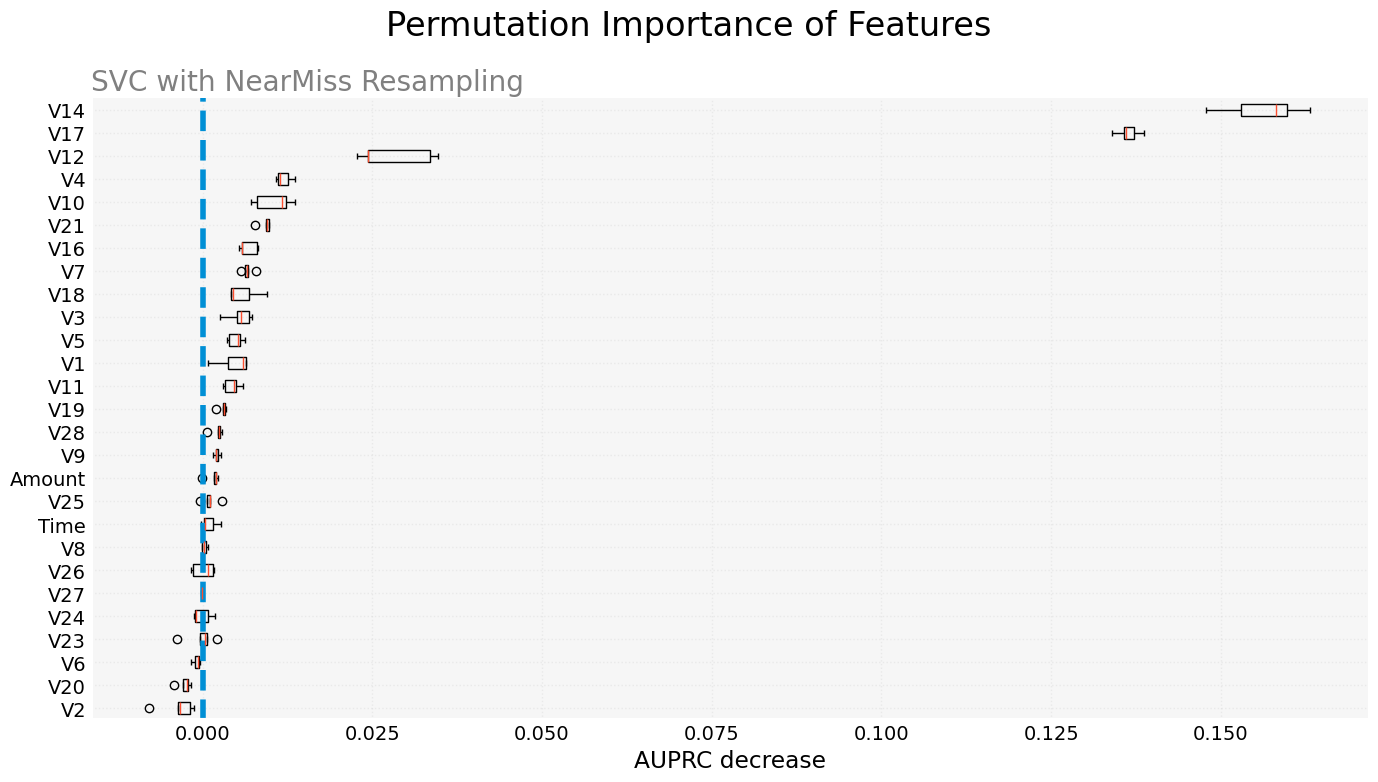

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE, stratify=y
)

clf = grid_search.best_estimator_

clf.fit(X_train, y_train)

perm_imp = permutation_importance(
    clf,
    X_test,
    y_test,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="average_precision",
)

fig, ax = plt.subplots()

order = perm_imp.importances_mean.argsort()

ax.boxplot(perm_imp.importances[order].T, vert=False, tick_labels=X.columns[order])
ax.axvline(x=0, linestyle="--")
ax.set_xlabel("AUPRC decrease")
ax.grid(True, linestyle=":")

fig.suptitle("Permutation Importance of Features")
ax.set_title("SVC with NearMiss Resampling")

plt.show()

It is interesting that the same features that were important for KNN are also important for SVC even after resampling. Since we don't know the original features, those that originated the PCA components, we can't say much about the features themselves. But we can say that the components are significant for the model.

The model can be exported to be used in a production environment or in future analysis, like the one we are going to do in the next notebook:

In [25]:
joblib.dump(grid_search.best_estimator_, BEST_MODEL_FILE)

['/home/chicolucio/Dropbox/technology/python/projects/ml/fraud/models/best_model.joblib']

## Visualizing the model performance

We have seen before the metrics for our fine-tuned model. However, an image is worth a thousand words. Let's plot the ROC curve, the precision-recall curve and confusion matrices to visualize the performance of our model. One should have in mind, though, that these visualizations are not ideal to measure generalization performance. They are more useful to summarize the results and to communicate the performance of the model to (technical) stakeholders.

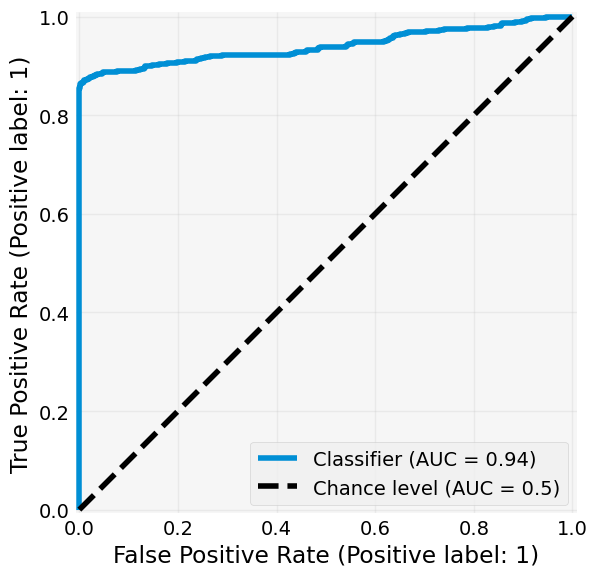

In [26]:
y_pred = cross_val_predict(
    grid_search.best_estimator_, X, y, cv=kf, n_jobs=-1, method="decision_function"
)

fig, ax = plt.subplots(figsize=(8, 6))

roc = RocCurveDisplay.from_predictions(y, y_pred, ax=ax, plot_chance_level=True)

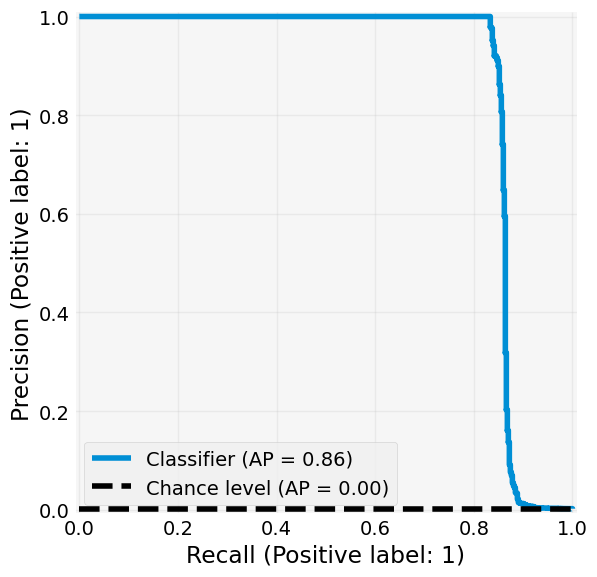

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

prc = PrecisionRecallDisplay.from_predictions(y, y_pred, ax=ax, plot_chance_level=True)

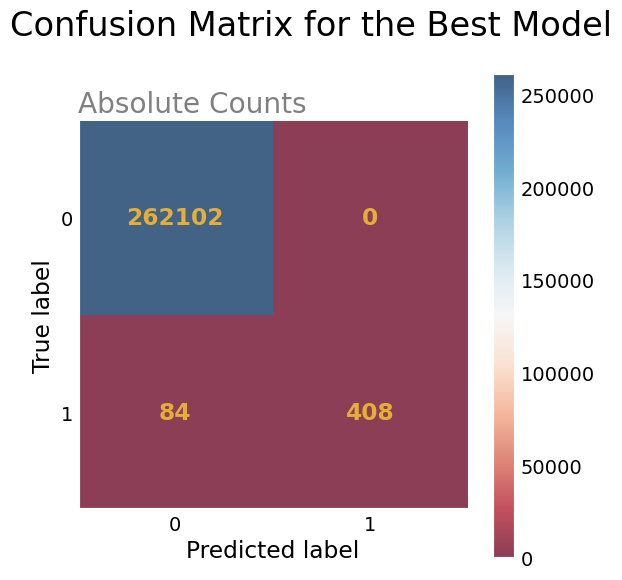

In [28]:
y_pred = cross_val_predict(
    grid_search.best_estimator_, X, y, cv=kf, n_jobs=-1, method="predict"
)

fig, ax = plt.subplots(figsize=(6, 6))

ConfusionMatrixDisplay.from_predictions(
    y,
    y_pred,
    ax=ax,
    cmap="RdBu",
    im_kw={"alpha": 0.75},
    text_kw={"size": "large", "color": "C2", "fontweight": "bold"},
)

fig.suptitle("Confusion Matrix for the Best Model")
ax.set_title("Absolute Counts")

plt.grid(False)
plt.show()

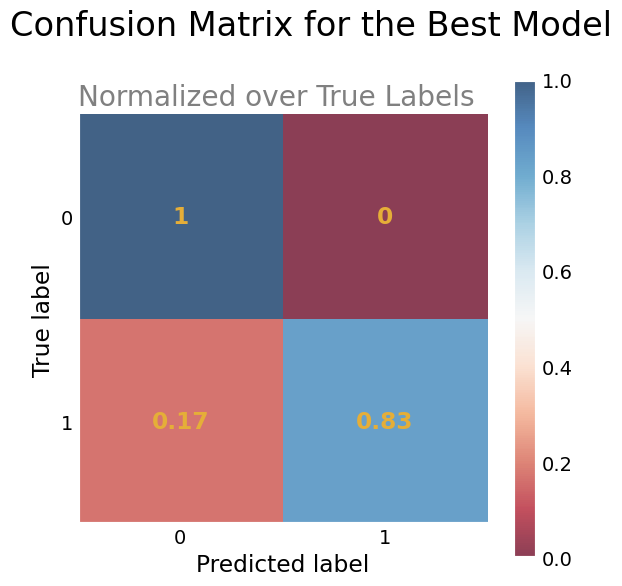

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))

ConfusionMatrixDisplay.from_predictions(
    y,
    y_pred,
    normalize="true",
    ax=ax,
    cmap="RdBu",
    im_kw={"alpha": 0.75},
    text_kw={"size": "large", "color": "C2", "fontweight": "bold"},
)

fig.suptitle("Confusion Matrix for the Best Model")
ax.set_title("Normalized over True Labels")

plt.grid(False)
plt.show()

Another plot that could be interesting, although not so common, is the Kolmogorov-Smirnov plot.

The Kolmogorov-Smirnov (KS) plot is a way to check how well a binary classification model separates two groups: positives (class = 1) and negatives (class = 0). It helps us understand if the model is making clear distinctions between the two classes based on the probabilities it assigns.

The KS plot is based on something called the Cumulative Distribution Function (CDF), which is just a way of showing how the probabilities are distributed in each class. Imagine listing all predicted probabilities for a class in order from smallest to largest. The CDF tells us, for each probability value, how many cases fall at or below that value.

Consider plot below:

- The blue line represents the positive class (y=1). It shows how many actual positive cases have a predicted probability less than or equal to a given value.
- The red line represents the negative class (y=0). It shows how many actual negative cases have a predicted probability less than or equal to that value.
- The KS statistic is the biggest vertical gap between the two lines. This gap tells us how well the model is distinguishing between positives and negatives.

The KS statistic is a number between 0 and 1 that indicates how well the model separates the two classes:

- A high KS value (closer to 1) means the model is doing a good job distinguishing between positives and negatives.
- A low KS value (close to 0) means the model struggles to tell the two classes apart.

If the KS value is greater than 0.4, it usually means the model is making strong distinctions between the two classes.

This plot is a great way to visually confirm how well a model is performing beyond standard metrics like accuracy and AUC-ROC.


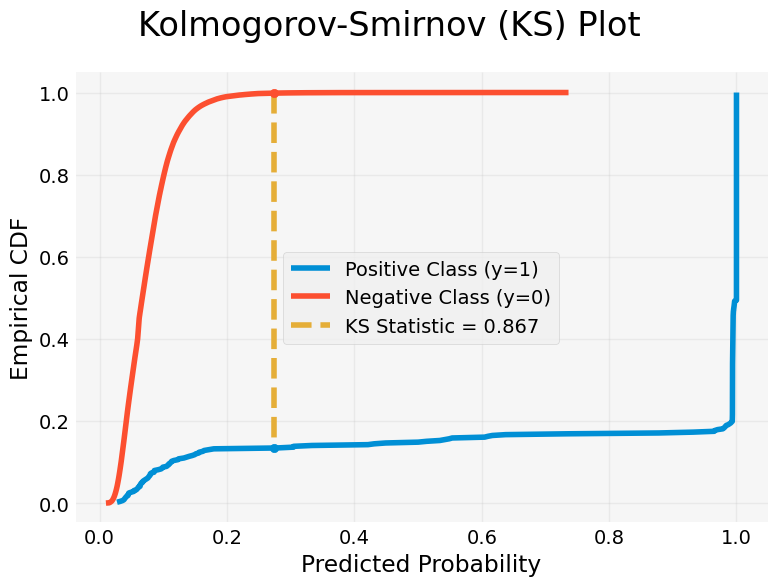

In [30]:
# get probabilities for the best model
y_pred_proba = grid_search.best_estimator_.predict_proba(X)[:, 1]

plot_ks_curve(y, y_pred_proba)